In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

from scipy.stats import mode 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_samples, silhouette_score

import math

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
data_dir = '../../../data/processed/Distrito_QRO/'

In [3]:
# hex_cluster = gpd.read_file('../data/processed/hex_clusters.geojson')

In [4]:
# hex_cluster.groupby('cluster').agg(['mean','median','std','count']).to_csv('../data/processed/cluster_stats.csv')

In [5]:
# hex_cluster.groupby('cluster').agg('mean','median','std').to_csv('../data/processed/cluster_stats_mean.csv')

In [6]:
hex_socio = gpd.read_file(f'{data_dir}hex_sociodemographic.geojson')
hex_eco = gpd.read_file(f'{data_dir}hex_economic.geojson')
hex_infra = gpd.read_file(f'{data_dir}hex_infraestructura.geojson')
hex_env = gpd.read_file(f'{data_dir}hex_environmental.geojson')
# hex_con = gpd.read_file(f'{data_dir}hex_connectivity.geojson')
hex_us = gpd.read_file(f'{data_dir}hex_urban_structure.geojson')
hex_prox = gpd.read_file(f'{data_dir}hex_proximity.geojson')

## Data treatment

In [7]:
hex_gdf = hex_eco[['hex_id_9','geometry']].copy()
print(hex_gdf.shape)
hex_gdf.head(2)

(2826, 2)


,hex_id_9,geometry
0,8949822402fffff,"POLYGON ((-100.2089 20.74718, -100.20765 20.74..."
1,89498224103ffff,"POLYGON ((-100.22424 20.75045, -100.223 20.752..."


#### Filter

In [8]:
hex_filter = gpd.read_file(f'{data_dir}hex_filter.geojson')
hex_gdf = hex_gdf.loc[hex_gdf.hex_id_9.isin(list(hex_filter.hex_id_9.unique()))]
print(hex_gdf.shape)
hex_gdf.head(2)

(1603, 2)


,hex_id_9,geometry
395,894983c1007ffff,"POLYGON ((-100.46527 20.60861, -100.46403 20.6..."
400,894983c1023ffff,"POLYGON ((-100.46777 20.614, -100.46652 20.615..."


### Sociodemographic

In [9]:
hex_socio.head(2)

,hex_id_9,CVEGEO,NOMGEO,city,type,nse_idx,hex_id,graproes,dens_pob_ha,auto_viv,pct_0_17,pct_18_59,pct_60_mas,wgt_imn,geometry
0,894983d8997ffff,22006,Corregidora,Queretaro,urban,1.082073,894983d8997ffff,14.780002,89.544734,0.905081,0.250115,0.651626,0.098259,0.980891,"POLYGON ((-100.45238 20.55939, -100.45114 20.5..."
1,894983c3697ffff,22006,Corregidora,Queretaro,urban,0.758296,894983c3697ffff,13.850000,18.383166,0.871094,0.294511,0.662651,0.042838,0.974732,"POLYGON ((-100.47848 20.52605, -100.47723 20.5..."


In [10]:
hex_socio = hex_socio[['hex_id_9','nse_idx','graproes',
                       'dens_pob_ha',
                       'auto_viv','pct_0_17','pct_18_59',
                       'pct_60_mas','wgt_imn']]
socio_cols = ['nse_idx',
              'graproes','dens_pob_ha',
                       'auto_viv','pct_0_17','pct_18_59',
                       'pct_60_mas','wgt_imn']
hex_socio = hex_socio.fillna(0)
hex_socio_std = hex_socio.copy()
hex_socio_std[socio_cols] = StandardScaler().fit_transform(np.array(hex_socio[socio_cols]))
print(hex_socio_std.shape)
hex_socio_std.head(2)

(2826, 9)


,hex_id_9,nse_idx,graproes,dens_pob_ha,auto_viv,pct_0_17,pct_18_59,pct_60_mas,wgt_imn
0,894983d8997ffff,1.147255,0.990818,1.074297,1.062956,0.003489,0.498568,0.083918,0.424616
1,894983c3697ffff,0.803974,0.785568,-0.471881,0.946265,0.338339,0.551228,-0.751714,0.404055


In [11]:
pca = PCA(n_components=3)

x = hex_socio_std.loc[:, socio_cols].values

principalComponents = pca.fit_transform(x)

In [12]:
print('Explained ratio:',pca.explained_variance_ratio_,'Explained variance:',pca.explained_variance_ratio_.sum())

Explained ratio: [0.5218372  0.20631581 0.11278198] Explained variance: 0.840934989937655


In [13]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc_1', 'pc_2','pc_3'])

hex_socio_pca = hex_socio[['hex_id_9']]
hex_socio_pca.loc[:,['socio_pc_1','socio_pc_2','socio_pc_3']]= np.nan, np.nan, np.nan
hex_socio_pca.loc[:,'socio_pc_1'] = principalDf['pc_1'].copy()
hex_socio_pca.loc[:,'socio_pc_2'] = principalDf['pc_2'].copy()
hex_socio_pca.loc[:,'socio_pc_3'] = principalDf['pc_3'].copy()

### Economic

In [14]:
hex_eco.head(2)

,hex_id_9,denue_count,denue_jobs,denue_0_5,denue_6_10,denue_11_30,denue_31_50,denue_51_100,denue_101_250,denue_250_mas,denue_jobs_>_11,pct_jobs_>_11,Comercio,Gubernamental,Industria,Otros,Servicios,per_ocu_tot,geometry
0,8949822402fffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,"POLYGON ((-100.2089 20.74718, -100.20765 20.74..."
1,89498224103ffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,"POLYGON ((-100.22424 20.75045, -100.223 20.752..."


In [15]:
hex_eco = hex_eco[['hex_id_9','denue_count','denue_jobs','denue_jobs_>_11',
                   'pct_jobs_>_11','Comercio','Gubernamental','Industria',
                  'Servicios','Otros']]
eco_cols = ['denue_count','denue_jobs','denue_jobs_>_11',
                   'pct_jobs_>_11','Comercio','Gubernamental','Industria',
                  'Servicios','Otros']
hex_eco = hex_eco.fillna(0)
hex_eco_std = hex_eco.copy()
hex_eco_std[eco_cols] = StandardScaler().fit_transform(np.array(hex_eco[eco_cols]))
print(hex_eco_std.shape)
hex_eco_std.head(2)

(2826, 10)


,hex_id_9,denue_count,denue_jobs,denue_jobs_>_11,pct_jobs_>_11,Comercio,Gubernamental,Industria,Servicios,Otros
0,8949822402fffff,-0.62105,-0.603395,-0.571495,-1.919701,-0.785512,-0.157656,-0.402163,-0.852748,-0.285854
1,89498224103ffff,-0.62105,-0.603395,-0.571495,-1.919701,-0.785512,-0.157656,-0.402163,-0.852748,-0.285854


In [16]:
pca = PCA(n_components=5)

x = hex_eco_std.loc[:, eco_cols].values

principalComponents = pca.fit_transform(x)

In [17]:
print('Explained ratio:',pca.explained_variance_ratio_,'Explained variance:',pca.explained_variance_ratio_.sum())

Explained ratio: [0.36093916 0.13069133 0.11688086 0.1105509  0.1015659 ] Explained variance: 0.8206281469234767


In [18]:
hex_eco_pca = hex_eco[['hex_id_9']]
hex_eco_pca.loc[:,['eco_pc_1','eco_pc_2','eco_pc_3',
                  'eco_pc_4','eco_pc_5']] = np.nan, np.nan, np.nan, np.nan, np.nan
hex_eco_pca.loc[:,'eco_pc_1'] = principalComponents[:,0]
hex_eco_pca.loc[:,'eco_pc_2'] = principalComponents[:,1]
hex_eco_pca.loc[:,'eco_pc_3'] = principalComponents[:,2]
hex_eco_pca.loc[:,'eco_pc_4'] = principalComponents[:,3]
hex_eco_pca.loc[:,'eco_pc_5'] = principalComponents[:,4]

### Infraestructure

In [19]:
hex_infra.head(2)

,hex_id_9,CVEGEO,NOMGEO,city,type,pct_BANQUETA,pct_ALUMPUB,pct_RAMPAS,pct_ARBOLES,pct_CICLOVIA,geometry
0,894983d8997ffff,22006,Corregidora,Queretaro,urban,0.000000,0.000000,0.00000,0.0,0.0,"POLYGON ((-100.45238 20.55939, -100.45114 20.5..."
1,894983c3697ffff,22006,Corregidora,Queretaro,urban,0.965128,0.930407,0.32933,0.0,0.0,"POLYGON ((-100.47848 20.52605, -100.47723 20.5..."


In [20]:
hex_infra = hex_infra[['hex_id_9','pct_BANQUETA','pct_ALUMPUB',
                      'pct_RAMPAS','pct_ARBOLES','pct_CICLOVIA']]
infra_cols = ['pct_BANQUETA','pct_ALUMPUB',
                      'pct_RAMPAS','pct_ARBOLES','pct_CICLOVIA']
hex_infra = hex_infra.fillna(0)
hex_infra_std = hex_infra.copy()
hex_infra_std[infra_cols] = StandardScaler().fit_transform(np.array(hex_infra[infra_cols]))
print(hex_infra_std.shape)
hex_infra_std.head(2)

(2826, 6)


,hex_id_9,pct_BANQUETA,pct_ALUMPUB,pct_RAMPAS,pct_ARBOLES,pct_CICLOVIA
0,894983d8997ffff,-1.286511,-1.358747,-0.515322,-1.197125,-0.221583
1,894983c3697ffff,1.002912,1.395583,1.053590,-1.197125,-0.221583


In [21]:
pca = PCA(n_components=3)

x = hex_infra_std.loc[:, infra_cols].values

principalComponents = pca.fit_transform(x)

In [22]:
print('Explained ratio:',pca.explained_variance_ratio_,'Explained variance:',pca.explained_variance_ratio_.sum())

Explained ratio: [0.49067994 0.18764072 0.17590871] Explained variance: 0.8542293690664409


In [23]:
hex_infra_pca = hex_infra[['hex_id_9']]
hex_infra_pca.loc[:,['infra_pc_1','infra_pc_2','infra_pc_3']]= np.nan, np.nan, np.nan
hex_infra_pca.loc[:,'infra_pc_1'] = principalComponents[:,0].copy()
hex_infra_pca.loc[:,'infra_pc_2'] = principalComponents[:,1].copy()
hex_infra_pca.loc[:,'infra_pc_2'] = principalComponents[:,2].copy()

### Environment

In [24]:
hex_env.head(2)

,hex_id_9,CVEGEO,NOMGEO,city,type,ndvi_mean,area_m2,area_pob,hex_id,temp_diff_mean,geometry
0,894983d8997ffff,22006,Corregidora,Queretaro,urban,0.173743,52660.963372,54.800149,894983d8997ffff,-0.013136,"POLYGON ((-100.45238 20.55939, -100.45114 20.5..."
1,894983c3697ffff,22006,Corregidora,Queretaro,urban,0.179758,50155.306891,198.713365,894983c3697ffff,1.889006,"POLYGON ((-100.47848 20.52605, -100.47723 20.5..."


In [25]:
hex_env = hex_env[['hex_id_9','ndvi_mean','temp_diff_mean',
                   'area_m2','area_pob',]]
env_cols = ['ndvi_mean','area_m2','area_pob','temp_diff_mean']
hex_env = hex_env.fillna(0)
hex_env_std = hex_env.copy()
hex_env_std[env_cols] = StandardScaler().fit_transform(np.array(hex_env[env_cols]))
print(hex_env_std.shape)
hex_env_std.head(2)

(2826, 5)


,hex_id_9,ndvi_mean,temp_diff_mean,area_m2,area_pob
0,894983d8997ffff,-0.438918,0.139093,1.384142,0.356538
1,894983c3697ffff,-0.368049,1.195658,1.286392,2.826621


In [26]:
pca = PCA(n_components=2)

x = hex_env_std.loc[:, env_cols].values

principalComponents = pca.fit_transform(x)

In [27]:
print('Explained ratio:',pca.explained_variance_ratio_,'Explained variance:',pca.explained_variance_ratio_.sum())

Explained ratio: [0.47181914 0.33810663] Explained variance: 0.809925762957461


In [28]:
hex_env_pca = hex_env[['hex_id_9']]
hex_env_pca.loc[:,['env_pc_1','env_pc_2']] = np.nan, np.nan
hex_env_pca.loc[:,'env_pc_1'] = principalComponents[:,0].copy()
hex_env_pca.loc[:,'env_pc_2'] = principalComponents[:,1].copy()

### Connectivity

In [29]:
hex_con = hex_con[['hex_id_9','dist_ciclo','ruta_count',
                  'dist_tp','dist_tpm']]
conn_cols = ['dist_ciclo','ruta_count',
                  'dist_tp','dist_tpm']
hex_con = hex_con.fillna(0)
hex_con_std = hex_con.copy()
hex_con_std[conn_cols] = StandardScaler().fit_transform(np.array(hex_con[conn_cols]))
print(hex_con_std.shape)
hex_con_std.head(2)

NameError: name 'hex_con' is not defined

In [30]:
pca = PCA(n_components=2)

x = hex_con_std.loc[:, conn_cols].values

principalComponents = pca.fit_transform(x)

NameError: name 'hex_con_std' is not defined

In [22]:
print('Explained ratio:',pca.explained_variance_ratio_,'Explained variance:',pca.explained_variance_ratio_.sum())

Explained ratio: [0.52776501 0.28335031] Explained variance: 0.8111153169189178


In [23]:
hex_con_pca = hex_con[['hex_id_9']]
hex_con_pca.loc[:,'conn_pc_1'] = principalComponents[:,0].copy()
hex_con_pca.loc[:,'conn_pc_2'] = principalComponents[:,1].copy()

/tmp/ipykernel_50183/986357026.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hex_con_pca.loc[:,'conn_pc_1'] = principalComponents[:,0].copy()
/tmp/ipykernel_50183/986357026.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hex_con_pca.loc[:,'conn_pc_2'] = principalComponents[:,1].copy()


### Urban structure

In [31]:
hex_us.head(2)

,hex_id_9,CVEGEO,NOMGEO,city,type,pct,street_dens,geometry
0,894983d8997ffff,22006,Corregidora,Queretaro,urban,0.515703,0.483324,"POLYGON ((-100.45238 20.55939, -100.45114 20.5..."
1,894983c3697ffff,22006,Corregidora,Queretaro,urban,0.512608,0.149998,"POLYGON ((-100.47848 20.52605, -100.47723 20.5..."


In [32]:
hex_us = hex_us[['hex_id_9','pct','street_dens']]
us_cols = ['pct','street_dens']
hex_us = hex_us.fillna(0)
hex_us_std = hex_us.copy()
hex_us_std[us_cols] = StandardScaler().fit_transform(np.array(hex_us[us_cols]))
print(hex_us_std.shape)
hex_us_std.head(2)

(2747, 3)


,hex_id_9,pct,street_dens
0,894983d8997ffff,-1.088851,0.038777
1,894983c3697ffff,-1.108173,-0.815817


In [33]:
pca = PCA(n_components=2)

x = hex_us_std.loc[:, us_cols].values

principalComponents = pca.fit_transform(x)

In [34]:
print('Explained ratio:',pca.explained_variance_ratio_,'Explained variance:',pca.explained_variance_ratio_.sum())

Explained ratio: [0.70478017 0.29521983] Explained variance: 1.0


In [35]:
hex_us_pca = hex_us[['hex_id_9']]
hex_us_pca.loc[:,['us_pc_1','us_pc_2']] = np.nan, np.nan
hex_us_pca.loc[:,'us_pc_1'] = principalComponents[:,0].copy()
hex_us_pca.loc[:,'us_pc_2'] = principalComponents[:,1].copy()

### Proximity

In [36]:
hex_prox.head(2)

,hex_id,res,max_escuelas,max_preescolar,max_primaria,max_secundaria,max_servicios comunitarios,max_salud,max_guarderías,max_asistencia social,...,p_0a5,p_6a11,p_12a17,p_18a24,p_25a59,p_60ymas,pcon_disc,dens_pob_ha,city,geometry
0,894983c82abffff,9,115.114797,106.785267,99.596546,115.114797,182.399401,88.479415,132.391653,182.399401,...,0.071186,0.213558,0.142372,0.000000,0.640674,0.213558,0.098565,0.105159,Queretaro,"POLYGON ((-100.34957 20.67921, -100.34832 20.6..."
1,894983c1c17ffff,9,164.601630,84.998281,95.620816,164.601630,278.369528,93.736007,96.915863,278.369528,...,0.939222,0.784411,0.942674,2.511496,8.012728,4.393392,1.150239,1.441855,Queretaro,"POLYGON ((-100.50637 20.63325, -100.50512 20.6..."


In [37]:
hex_prox.columns

Index(['hex_id', 'res', 'max_escuelas', 'max_preescolar', 'max_primaria',
       'max_secundaria', 'max_servicios comunitarios', 'max_salud',
       'max_guarderías', 'max_asistencia social', 'max_comercio',
       'max_alimentos', 'max_personal', 'max_farmacias', 'max_hogar',
       'max_complementarios', 'max_entretenimiento', 'max_social',
       'max_actividad física', 'max_cultural', 'escuelas_15min',
       'preescolar_15min', 'primaria_15min', 'secundaria_15min',
       'servicios comunitarios_15min', 'salud_15min', 'guarderías_15min',
       'asistencia social_15min', 'comercio_15min', 'alimentos_15min',
       'personal_15min', 'farmacias_15min', 'hogar_15min',
       'complementarios_15min', 'entretenimiento_15min', 'social_15min',
       'actividad física_15min', 'cultural_15min', 'idx_preescolar',
       'idx_primaria', 'idx_secundaria', 'idx_salud', 'idx_guarderías',
       'idx_asistencia social', 'idx_alimentos', 'idx_personal',
       'idx_farmacias', 'idx_hogar', 'idx_

In [38]:
hex_prox = hex_prox.rename(columns={'hex_id':'hex_id_9'})

In [39]:
hex_prox = hex_prox[['hex_id_9','max_time',
                    'max_entretenimiento','max_comercio',
                    'max_servicios comunitarios','max_escuelas',
                    'escuelas_15min','servicios comunitarios_15min',
                    'comercio_15min','entretenimiento_15min',
                    'idx_sum']]
prox_cols = ['max_time',
                    'max_entretenimiento','max_comercio',
                    'max_servicios comunitarios','max_escuelas',
                    'escuelas_15min','servicios comunitarios_15min',
                    'comercio_15min','entretenimiento_15min',
                    'idx_sum']
hex_prox = hex_prox.fillna(0)
hex_prox_std = hex_prox.copy()
hex_prox_std[prox_cols] = StandardScaler().fit_transform(np.array(hex_prox[prox_cols]))
print(hex_prox.shape)
hex_prox.head(2)

(2766, 11)


,hex_id_9,max_time,max_entretenimiento,max_comercio,max_servicios comunitarios,max_escuelas,escuelas_15min,servicios comunitarios_15min,comercio_15min,entretenimiento_15min,idx_sum
0,894983c82abffff,182.399401,179.419393,93.784799,182.399401,115.114797,0.0,0.0,0.0,0.0,0.003558
1,894983c1c17ffff,278.369528,127.009870,80.033691,278.369528,164.601630,0.0,0.0,0.0,0.0,0.005202


In [40]:
pca = PCA(n_components=3)

x = hex_prox_std.loc[:, prox_cols].values

principalComponents = pca.fit_transform(x)

In [41]:
print('Explained ratio:',pca.explained_variance_ratio_,'Explained variance:',pca.explained_variance_ratio_.sum())

Explained ratio: [0.56829949 0.20313205 0.10900875] Explained variance: 0.8804402911965317


In [42]:
hex_prox_pca = hex_prox[['hex_id_9']]
hex_prox_pca.loc[:,['prox_pc_1','prox_pc_2','prox_pc_3']]= np.nan, np.nan, np.nan
hex_prox_pca.loc[:,'prox_pc_1'] = principalComponents[:,0].copy()
hex_prox_pca.loc[:,'prox_pc_2'] = principalComponents[:,1].copy()
hex_prox_pca.loc[:,'prox_pc_2'] = principalComponents[:,2].copy()

## Merge data

In [43]:
hex_mrg = hex_gdf.merge(hex_socio, on='hex_id_9', how='left')
hex_mrg = hex_mrg.merge(hex_eco, on='hex_id_9', how='left')
hex_mrg = hex_mrg.merge(hex_infra, on='hex_id_9', how='left')
hex_mrg = hex_mrg.merge(hex_env, on='hex_id_9', how='left')
# hex_mrg = hex_mrg.merge(hex_con, on='hex_id_9', how='left')
hex_mrg = hex_mrg.merge(hex_us, on='hex_id_9', how='left')
hex_mrg = hex_mrg.merge(hex_prox, on='hex_id_9', how='left')

In [44]:
print(hex_gdf.shape)
hex_gdf.head(2)

(1603, 2)


,hex_id_9,geometry
395,894983c1007ffff,"POLYGON ((-100.46527 20.60861, -100.46403 20.6..."
400,894983c1023ffff,"POLYGON ((-100.46777 20.614, -100.46652 20.615..."


In [45]:
hex_pca = hex_gdf.merge(hex_socio_pca, on='hex_id_9', how='left')
hex_pca = hex_pca.merge(hex_eco_pca, on='hex_id_9', how='left')
hex_pca = hex_pca.merge(hex_infra_pca, on='hex_id_9', how='left')
hex_pca = hex_pca.merge(hex_env_pca, on='hex_id_9', how='left')
# hex_pca = hex_pca.merge(hex_con_pca, on='hex_id_9', how='left')
hex_pca = hex_pca.merge(hex_us_pca, on='hex_id_9', how='left')
hex_pca = hex_pca.merge(hex_prox_pca, on='hex_id_9', how='left')
hex_pca = hex_pca.fillna(0)

## k-means

In [46]:
data = hex_pca.drop(columns=['hex_id_9','geometry']).to_numpy()

In [47]:
hex_pca.isna().sum()

hex_id_9      0
geometry      0
socio_pc_1    0
socio_pc_2    0
socio_pc_3    0
eco_pc_1      0
eco_pc_2      0
eco_pc_3      0
eco_pc_4      0
eco_pc_5      0
infra_pc_1    0
infra_pc_2    0
infra_pc_3    0
env_pc_1      0
env_pc_2      0
us_pc_1       0
us_pc_2       0
prox_pc_1     0
prox_pc_2     0
prox_pc_3     0
dtype: int64

{2: np.float64(0.21103625621559574), 3: np.float64(0.17434759388809068), 4: np.float64(0.1649450291799249), 5: np.float64(0.15647112459711549), 6: np.float64(0.16421708457079412), 7: np.float64(0.1602783150296061), 8: np.float64(0.15766624744996927), 9: np.float64(0.1515208331979592), 10: np.float64(0.15861690060889863), 11: np.float64(0.1618092305148297), 12: np.float64(0.15991917579358764), 13: np.float64(0.16674938252433097), 14: np.float64(0.15424676695227055), 15: np.float64(0.1604391211337873), 16: np.float64(0.15507185110494076), 17: np.float64(0.15924729019827416), 18: np.float64(0.15010294164056184), 19: np.float64(0.14081525398211264), 20: np.float64(0.14004968794646452), 21: np.float64(0.14142985545214054), 22: np.float64(0.1400504311030157), 23: np.float64(0.13912736952627733), 24: np.float64(0.14084270494877218), 25: np.float64(0.1395303818819818), 26: np.float64(0.1416175460210073), 27: np.float64(0.140806381632926), 28: np.float64(0.1388356777948261), 29: np.float64(0.13

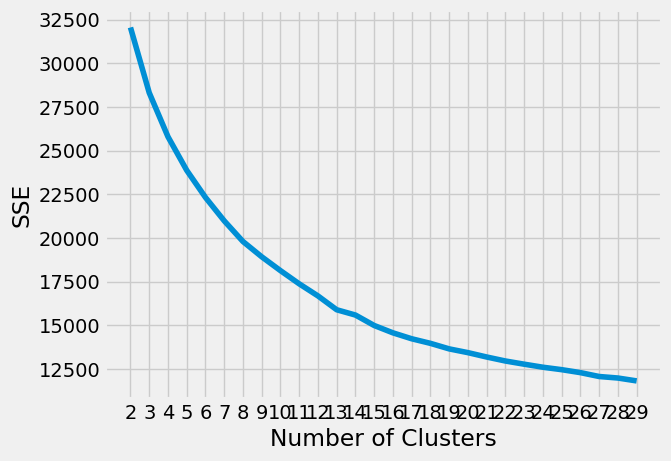

In [48]:
# Elbow curve to find optimal K 
kmeans_kwargs = {
    "init": "random",
    "n_init": 30,
    "max_iter": 300,
    "random_state": 42,
}

sse = []
silhouette_avg = {}
for k in range(2, 30):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    cluster_labels = kmeans.fit_predict(data)
    sse.append(kmeans.inertia_)
    silhouette_avg[k] = silhouette_score(data, cluster_labels)
    

print(silhouette_avg)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 30), sse)
plt.xticks(range(2, 30))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()


In [49]:
kmeans = KMeans(
    init="random",
    n_clusters=13,
    n_init=30,
    max_iter=300,
    random_state=42
)
clusters = kmeans.fit_predict(data) 
clusters

array([1, 1, 1, ..., 1, 1, 0], shape=(1603,), dtype=int32)

<Axes: >

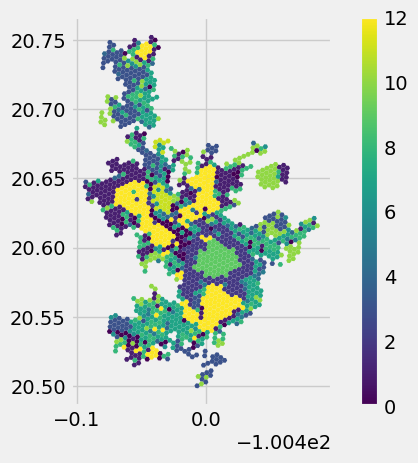

In [50]:
hex_mrg['cluster'] = clusters
hex_mrg.plot('cluster', legend=True)

In [52]:
hex_mrg.groupby('cluster').mean(numeric_only=True)

,nse_idx,graproes,dens_pob_ha,auto_viv,pct_0_17,pct_18_59,pct_60_mas,wgt_imn,denue_count,denue_jobs,...,max_time,max_entretenimiento,max_comercio,max_servicios comunitarios,max_escuelas,escuelas_15min,servicios comunitarios_15min,comercio_15min,entretenimiento_15min,idx_sum
cluster,,,,,,,,,,,,,,,,,,,,,
0,-0.118934,11.130077,32.390543,0.631364,0.257970,0.627920,0.114110,0.956222,1382.137115,14055.277407,...,57.114760,32.193980,13.133741,55.024142,31.804568,2.552731,1.452014,58.036548,35.276362,10.695954
1,-0.359699,10.576886,94.071657,0.572672,0.316269,0.622390,0.061341,0.954315,1025.351340,5323.578143,...,101.730174,44.266745,9.347905,99.564406,33.931987,2.837684,1.727129,79.064219,36.489812,10.533156
2,0.527539,13.040845,54.052908,0.715025,0.170108,0.614517,0.215375,0.969767,3908.350621,34795.554992,...,29.092366,20.702146,6.818310,24.544547,19.527570,7.521053,7.996959,143.084292,108.521385,12.769357
3,1.052960,14.456998,12.804108,0.916098,0.261223,0.601289,0.137488,0.977952,167.648398,1830.547381,...,84.908550,58.095742,37.003503,83.504403,56.881326,0.171625,0.204737,3.753207,2.410227,4.978116
4,0.316754,11.399723,41.275165,0.669487,0.215236,0.594273,0.107158,0.884663,1155.036166,11588.566343,...,67.137382,38.802780,16.264087,65.544488,36.698496,1.805283,1.802618,40.168781,26.308259,9.840146
5,0.290624,12.138772,33.078248,0.672384,0.217965,0.647200,0.134835,0.926709,2113.777537,18369.679024,...,40.005980,26.922793,11.662359,35.142587,22.142048,3.932682,5.077218,86.111887,62.988469,11.662467
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.381520,520.847060,7681.414213,...,87.219490,48.770667,26.994814,86.627976,47.794175,0.333333,0.433985,15.966520,10.712536,7.742442
7,0.745850,13.612855,37.700194,0.836667,0.226396,0.626985,0.146619,0.955281,1023.133509,9913.915217,...,49.814868,34.030882,13.312158,45.494373,30.435682,2.236938,2.113131,37.486767,29.419229,10.773618
8,-0.074525,11.312643,43.210937,0.650076,0.276043,0.618501,0.105456,0.954444,857.751648,5998.486500,...,68.965130,38.655161,14.015937,65.661919,30.375990,2.665365,1.511700,50.567689,27.279803,10.305411


In [53]:
hex_mrg.groupby('cluster').count()

,hex_id_9,geometry,nse_idx,graproes,dens_pob_ha,auto_viv,pct_0_17,pct_18_59,pct_60_mas,wgt_imn,...,max_time,max_entretenimiento,max_comercio,max_servicios comunitarios,max_escuelas,escuelas_15min,servicios comunitarios_15min,comercio_15min,entretenimiento_15min,idx_sum
cluster,,,,,,,,,,,,,,,,,,,,,
0,89,89,89,89,89,89,89,89,89,89,...,89,89,89,89,89,89,89,89,89,89
1,209,209,209,209,209,209,209,209,209,209,...,209,209,209,209,209,209,209,209,209,209
2,147,147,147,147,147,147,147,147,147,147,...,147,147,147,147,147,147,147,147,147,147
3,184,184,184,184,184,184,184,184,184,184,...,184,184,184,184,184,184,184,184,184,184
4,48,48,48,48,48,48,48,48,48,48,...,48,48,48,48,48,48,48,48,48,48
5,24,24,24,24,24,24,24,24,24,24,...,24,24,24,24,24,24,24,24,24,24
6,33,33,33,33,33,33,33,33,33,33,...,24,24,24,24,24,24,24,24,24,24
7,215,215,215,215,215,215,215,215,215,215,...,215,215,215,215,215,215,215,215,215,215
8,175,175,175,175,175,175,175,175,175,175,...,175,175,175,175,175,175,175,175,175,175


In [54]:
hex_hm = hex_mrg.copy()
'''hex_hm = hex_hm.drop(columns=['denue_jobs_>_11','area_m2',
                               'denue_jobs','area_pob','denue_count',
                              'dens_pob_ha','wgt_imn','pct_jobs_>_11'])'''
hex_hm = hex_hm.groupby('cluster').mean(numeric_only=True)
# hex_hm = hex_hm.reset_index()

In [55]:
hex_hm.head(2)

,nse_idx,graproes,dens_pob_ha,auto_viv,pct_0_17,pct_18_59,pct_60_mas,wgt_imn,denue_count,denue_jobs,...,max_time,max_entretenimiento,max_comercio,max_servicios comunitarios,max_escuelas,escuelas_15min,servicios comunitarios_15min,comercio_15min,entretenimiento_15min,idx_sum
cluster,,,,,,,,,,,,,,,,,,,,,
0,-0.118934,11.130077,32.390543,0.631364,0.257970,0.62792,0.114110,0.956222,1382.137115,14055.277407,...,57.114760,32.193980,13.133741,55.024142,31.804568,2.552731,1.452014,58.036548,35.276362,10.695954
1,-0.359699,10.576886,94.071657,0.572672,0.316269,0.62239,0.061341,0.954315,1025.351340,5323.578143,...,101.730174,44.266745,9.347905,99.564406,33.931987,2.837684,1.727129,79.064219,36.489812,10.533156


In [56]:
he

NameError: name 'he' is not defined

In [57]:
scaler = StandardScaler()
scaled_cluster = scaler.fit_transform(hex_hm)

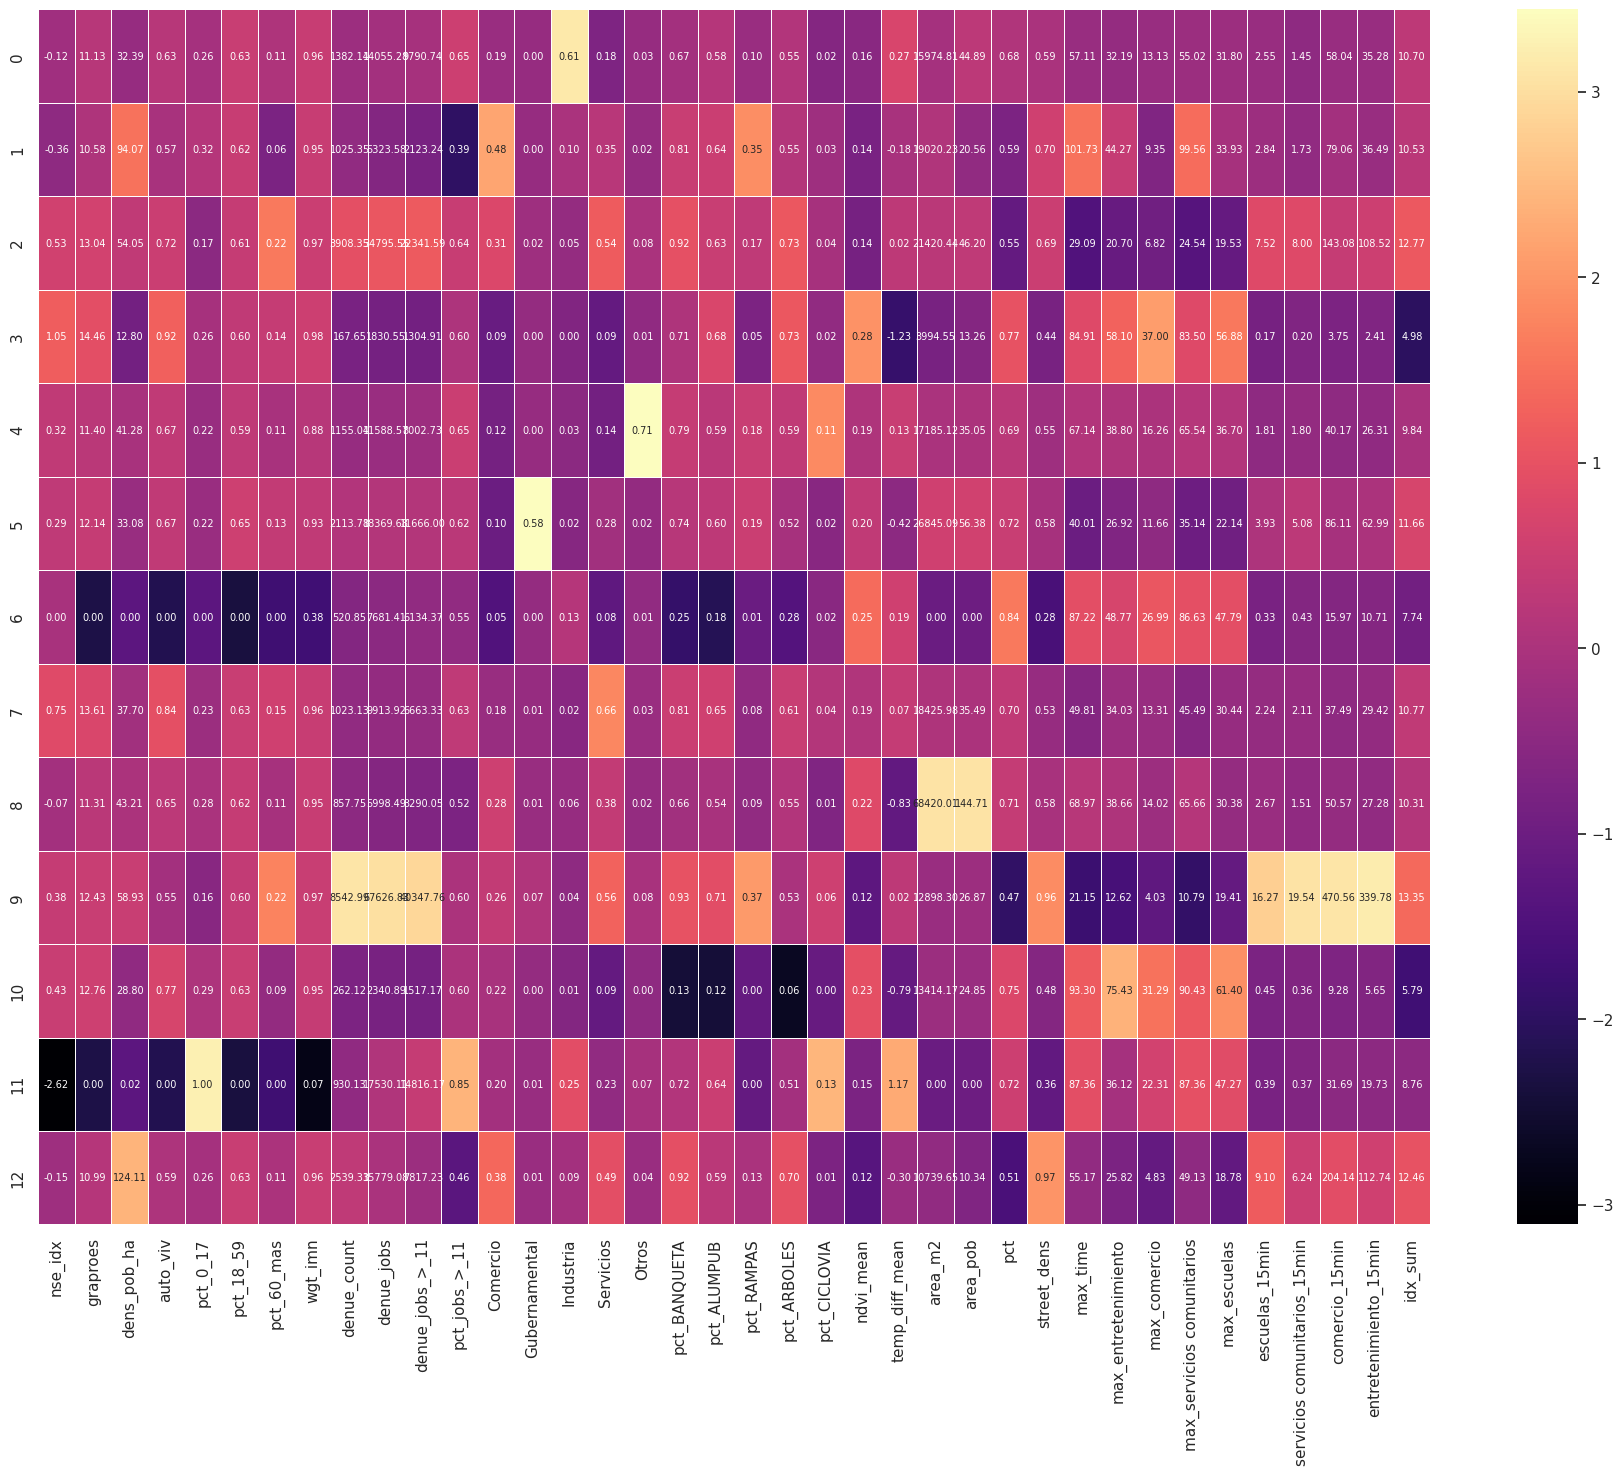

In [58]:
sns.set (rc = {'figure.figsize':(20,15)})

sns.heatmap(scaled_cluster, annot=hex_hm, 
            xticklabels=hex_hm.columns,
           fmt=".2f", linewidth=.5, cmap="magma",
           annot_kws={'size': 7})

plt.savefig('../../../output/figures/Distrito_QRO/Clusters_Statistical_Behaviour.png')

In [59]:
hex_mrg.to_file(f'{data_dir}hex_clusters.geojson')